# Reproducing the experiments from "Evidential Deep Learning" paper


Tests for Cross-Entropy (CE) loss with various evidence functions.

In [1]:
# imports

import os
import os.path as osp
import sys
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from mmengine import Config
from mmengine.dataset import default_collate
from mmpretrain.apis import get_model
from mmpretrain.registry import DATASETS
from mmpretrain.structures import DataSample

import torch
import torchvision.transforms.functional as TF

In [2]:
# include parent path
sys.path.append(os.path.abspath('..'))

In [16]:
# Configs


# ce + softplus
cfg = Config.fromfile('../configs/edl_mnist/edl-ce-softplus_lenet5_mnist.py')
ckpt = '../work_dirs/edl-ce-softplus_lenet5_mnist/epoch_30.pth'

# ce + exp
cfg = Config.fromfile('../configs/edl_mnist/edl-ce-exp_lenet5_mnist.py')
ckpt = '../work_dirs/edl-ce-exp_lenet5_mnist/epoch_30.pth'

# ce + exp_tanh
# cfg = Config.fromfile('../configs/edl_mnist/edl-ce-etanh_lenet5_mnist.py')
# ckpt = '../work_dirs/edl-ce-etanh_lenet5_mnist/epoch_30.pth'

assert osp.exists(ckpt)

First, we need to create a dataset with a single image and rotate it from 0 to 180 degrees. 

In [17]:
# avoid overwriting the original config
print(cfg.test_dataloader.dataset)
dataset_cfg: dict = deepcopy(cfg.test_dataloader.dataset)

# append '../' to the data_prefix
dataset_cfg['data_prefix'] = osp.join('../', dataset_cfg['data_prefix'])

dataset = DATASETS.build(dataset_cfg)
print(type(dataset))

# the "1" examples is the 2nd sample in the test dataset
sample = dataset[2]
print(sample['data_samples'].gt_label)

{'type': 'MNIST', 'data_prefix': 'data/mnist', 'pipeline': [{'type': 'Resize', 'scale': 32}, {'type': 'PackInputs'}], 'test_mode': True}
<class 'mmpretrain.datasets.mnist.MNIST'>
tensor([1])


In [18]:
# Create DataSample of Rotated MNIST

def create_rotated_mnist_sample(sample: dict):
    img: torch.Tensor = sample['inputs']
    data_sample: DataSample = sample['data_samples']

    m = 180
    n = m // 10 + 1
    degs = torch.linspace(0, m, n)
    samples = []
    for deg in degs:
        img_rot = TF.rotate(img.clone(), float(deg), fill=0)
        ds = data_sample.clone()
        ds.set_field(deg, 'rotation', torch.Tensor)
        samples.append(
            dict(
                inputs=img_rot,
                data_samples=ds,
            )
        )

    return samples

def make_batch(data: list):
    return default_collate(data)

samples = create_rotated_mnist_sample(sample)
data = make_batch(samples)

In [19]:
# Load the model
model = get_model(cfg, pretrained=ckpt)

Loads checkpoint by local backend from path: ../work_dirs/edl-ce-exp_lenet5_mnist_adam/epoch_30.pth


In [20]:
# inference
model.eval()
out = model.test_step(deepcopy(data))

[0. 7. 0. 0. 0. 0. 0. 0. 0. 0.]


<Figure size 620x500 with 0 Axes>

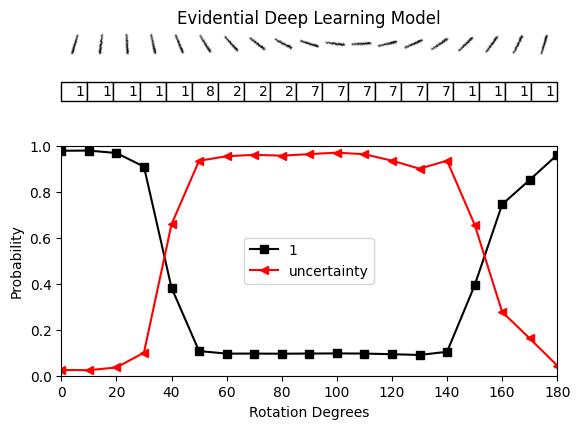

In [21]:
# edl plot
uncertainty = torch.stack([o.uncertainty for o in out])
probs = torch.stack([o.pred_score for o in out])
preds = probs.argmax(dim=-1)
imgs = torch.cat([s['inputs'] for s in samples], dim=-1).squeeze(0)
degs = torch.stack([o.rotation for o in out])

threshold = 0.4

# obtain labels where the probability is greater than `threshold`
scores = np.zeros((10))
for o in out:
    scores += o.pred_score.cpu().numpy() >=  threshold
print(scores)

labels = np.arange(10)[scores.astype(bool)].tolist()
lprobs = np.array(probs.cpu())[:, labels]

fig = plt.figure(figsize=[6.2, 5])
fig, (ax1, ax2, ax3) = plt.subplots(
    3,
    1,
    gridspec_kw={"height_ratios": [4, 1, 12]},
)

ax1.imshow(255 - imgs, cmap="gray")
ax1.axis(False)

empty_lst = []
empty_lst.append(preds.tolist())
ax2.table(cellText=empty_lst, bbox=[0, 1.2, 1, 1])
ax2.axis("off")

c = ["black", "blue", "brown", "purple", "cyan", "red"]
marker = ["s", "^", "o"] * 2

for i in range(len(labels)):
    ax3.plot(degs, lprobs[:, i], marker=marker[i], c=c[i])

labels += ["uncertainty"]
ax3.plot(degs, uncertainty, color="red", marker="<")

ax3.set_ylabel("Probability")
ax3.set_xlabel("Rotation Degrees")
ax3.legend(labels)
ax3.set_xlim([0, 180])
ax3.set_ylim([0, 1])

ax1.set_title('Evidential Deep Learning Model')
plt.show()

## Other Experiments (not in the paper)

The experiments are adapted from [pytorch-classification-uncertainty](https://github.com/dougbrion/pytorch-classification-uncertainty).

In [22]:
# imports

from PIL import Image

from mmengine.dataset import Compose
from mmpretrain.registry import TRANSFORMS

In [23]:
# get transform

pipeline = Compose(
    [TRANSFORMS.build(t) for t in cfg.test_dataloader.dataset.pipeline]
)

In [24]:
one_path = '../data/one.jpg'
one_img = np.array(Image.open(one_path).convert('L'))[..., None]

yoda_path = '../data/yoda.jpg'
yoda_img = np.array(Image.open(yoda_path).convert('L'))[..., None]

infos = [{'img': one_img}, {'img': yoda_img}]
samples = [pipeline(info) for info in infos]
data = make_batch(samples)

In [25]:
# inference
model.eval()
edl_out = model.test_step(deepcopy(data))

<Figure size 620x500 with 0 Axes>

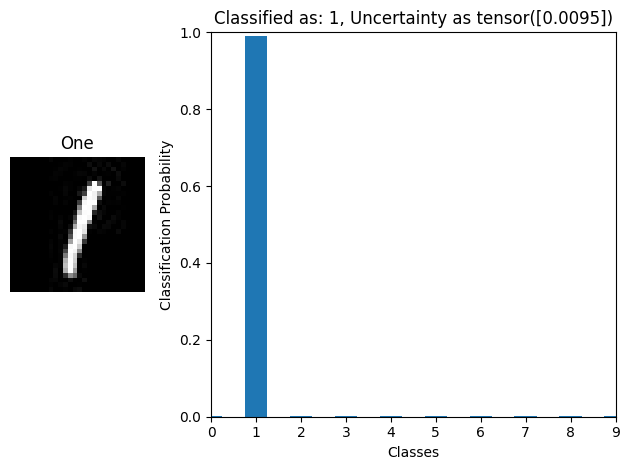

In [26]:
# one
pred_score = edl_out[0].pred_score.detach()  # softmax output
uncertainty = edl_out[0].uncertainty.detach()  # uncertainty
pred = pred_score.argmax().item()

labels = np.arange(10)
fig = plt.figure(figsize=[6.2, 5])
fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 3]})

plt.title("Classified as: {}, Uncertainty as {}".format(pred, uncertainty))

axs[0].set_title("One")
axs[0].imshow(one_img, cmap="gray")
axs[0].axis("off")

axs[1].bar(labels, pred_score.numpy(), width=0.5)
axs[1].set_xlim([0, 9])
axs[1].set_ylim([0, 1])
axs[1].set_xticks(np.arange(10))
axs[1].set_xlabel("Classes")
axs[1].set_ylabel("Classification Probability")

fig.tight_layout()

plt.show()

<Figure size 620x500 with 0 Axes>

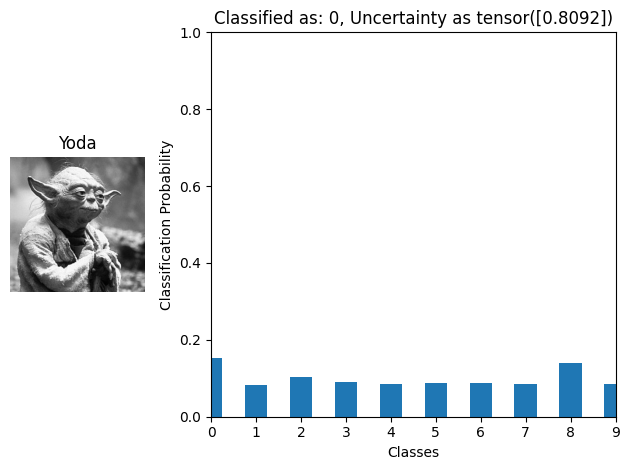

In [27]:
# yoda
pred_score = edl_out[1].pred_score.detach()  # softmax output
uncertainty = edl_out[1].uncertainty.detach()  # uncertainty
pred = pred_score.argmax().item()

labels = np.arange(10)
fig = plt.figure(figsize=[6.2, 5])
fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [1, 3]})

plt.title("Classified as: {}, Uncertainty as {}".format(pred, uncertainty))

axs[0].set_title("Yoda")
axs[0].imshow(yoda_img, cmap="gray")
axs[0].axis("off")

axs[1].bar(labels, pred_score.numpy(), width=0.5)
axs[1].set_xlim([0, 9])
axs[1].set_ylim([0, 1])
axs[1].set_xticks(np.arange(10))
axs[1].set_xlabel("Classes")
axs[1].set_ylabel("Classification Probability")

fig.tight_layout()

plt.show()